In [54]:
import matplotlib.pyplot as plt
import numpy as np 
import pickle
import time 
import pymc as pm
import pandas as pd 
import arviz as az
import statsmodels.api as sm
import bambi as bmb

/tmp/ipykernel_425/2330004159.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(X, cmap=plt.cm.get_cmap('gray').reversed())


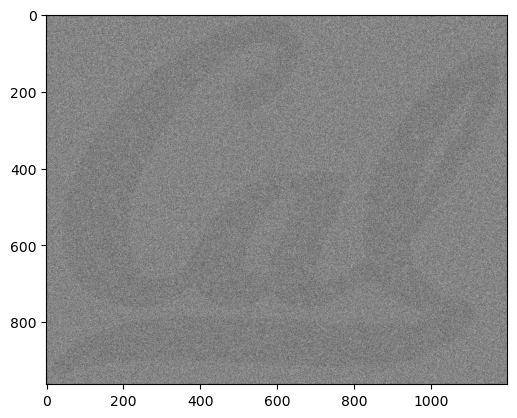

In [55]:
with open('X.pkl','rb') as f:
    X = pickle.load(f)
plt.imshow(X, cmap=plt.cm.get_cmap('gray').reversed())
plt.show()

/tmp/ipykernel_425/3075004489.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(Z, cmap=plt.cm.get_cmap('gray').reversed())


Time to run:   13.56729507446289


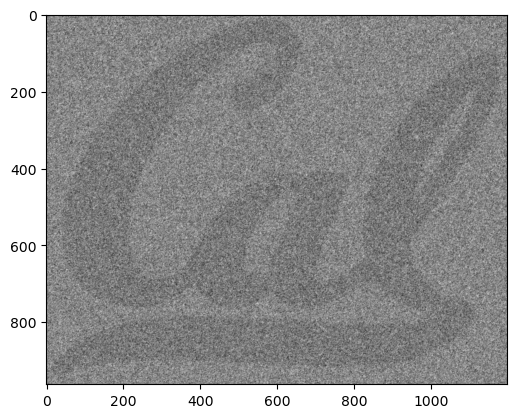

In [56]:
t0 = time.time()
Z = X
T = 1
a = 250
b = 62.5
tau = .01 
n = X.shape[0]
m=X.shape[1]
for t in range(T):
    for i in range(n):
        for j in range(m):
            N_curr = np.array([(i-1,j), (i, j-1), (i+1, j), (i, j+1)])
            S_curr = sum(Z[u, v] for (u,v) in N_curr if 0 <= v < m and 0 <= u < n)
            Z[i,j] = ((tau*X[i,j]+b*S_curr) / (a+tau)+np.random.randn() * np.sqrt(1/(a+tau)))
plt.imshow(Z, cmap=plt.cm.get_cmap('gray').reversed())
t1 = time.time()
print('Time to run:  ',t1 -t0)
plt.show()

Time to run:   8.00187349319458


/tmp/ipykernel_425/2570270222.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(Z, cmap = plt.cm.get_cmap('gray').reversed())


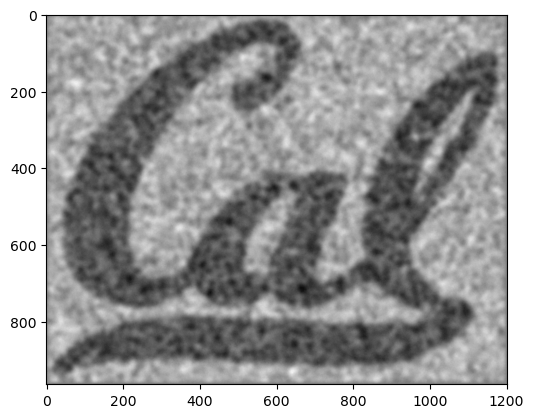

In [57]:
t0 = time.time()
A, B = np.meshgrid(np.arange(m), np.arange(n))
even_pre = (A+B) % 2 == 0
odd_pre = (A+B) % 2 == 1
Z = np.pad(X,1)
even = np.pad(even_pre,1)
odd = np.pad(odd_pre,1)
for _ in range(100):
    curr_s=Z[:-2,1:-1]+Z[1:-1,:-2]+Z[2:,1:-1]+Z[1:-1,2:]
    d=((tau*X+b*curr_s)/(a+tau)+np.random.randn(n, m)*np.sqrt(1/(a+tau)))
    Z[even]=np.pad(d*even_pre,1)[even]
    Z[odd]=np.pad(d*odd_pre,1)[odd]

t1=time.time()
print('Time to run:  ', t1-t0)
plt.imshow(Z, cmap = plt.cm.get_cmap('gray').reversed())
plt.show()

In [58]:
data = pd.read_csv('mroz2.csv')
data.head()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,hushrs,husage,huseduc,huswage,faminc,mtr,motheduc,fatheduc,unem,city,lwage
0,1,1610,1,0,32,12,3.3540,2708,34,12,4.0288,16310,0.7215,12,7,5.0,0,1.210154
1,1,1656,0,2,30,12,1.3889,2310,30,9,8.4416,21800,0.6615,7,7,11.0,1,0.328512
2,1,1980,1,3,35,12,4.5455,3072,40,12,3.5807,21040,0.6915,12,7,5.0,0,1.514138
3,1,456,0,3,34,12,1.0965,1920,53,10,3.5417,7300,0.7815,7,7,5.0,0,0.092123
4,1,1568,1,2,31,14,4.5918,2000,32,12,10.0000,27300,0.6215,12,14,9.5,1,1.524272


In [59]:
# Filter rows where inlf == 1
data_inlf = data[data['inlf'] == 1]

# Fit Poisson regression
poisson_model = sm.GLM(data_inlf['hours'], sm.add_constant(data_inlf[['kidslt6', 'kidsge6']]), family=sm.families.Poisson()).fit()

# Fit negative binomial regression
nb_model = sm.GLM(data_inlf['hours'], sm.add_constant(data_inlf[['kidslt6', 'kidsge6']]), family=sm.families.NegativeBinomial()).fit()

# Check for overdispersion in Poisson model
observed_counts = data_inlf['hours']
df = len(observed_counts) - poisson_model.df_model - 1
poisson_overdispersion = poisson_model.pearson_chi2 / df
print(poisson_overdispersion)
"""This is considered overdisperion by 
definiton because the pearsons_chi / degrees of freedome should be approximatley 1 or less than 1."""

456.0726770129682


/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


'This is considered overdisperion by \ndefiniton because the pearsons_chi / degrees of freedome should be approximatley 1 or less than 1.'

In [60]:
# Interpret coefficient for kidslt6 in negative binomial regression
print("For every additional child under 6 a woman has, the model predicts she’ll work", nb_model.params['kidslt6'], "hours.")


For every additional child under 6 a woman has, the model predicts she’ll work -0.25976317173587554 hours.


In [61]:
model1 = sm.GLM(data_inlf['hours'], sm.add_constant(data_inlf[['kidslt6', 'kidsge6']]), family=sm.families.NegativeBinomial()).fit()
model2 = sm.GLM(data_inlf['hours'], sm.add_constant(data_inlf[['kidslt6', 'kidsge6', 'husage', 'city']]), family=sm.families.NegativeBinomial()).fit()
model3 = sm.GLM(data_inlf['hours'], sm.add_constant(data_inlf[['hushrs', 'wage', 'motheduc', 'fatheduc']]), family=sm.families.NegativeBinomial()).fit()

# Compute AIC for each model
aic_model1 = model1.aic
aic_model2 = model2.aic
aic_model3 = model3.aic

# Determine which model has the lowest AIC
best_model = min(aic_model1, aic_model2, aic_model3)
print(aic_model3, aic_model2, aic_model1)
"""From this the best model is model 1 as it has the lowest AIC. This is the simpliest model with only ['kidslt6', 'kidsge6']"""

7002.994254537423 6995.633450600851 6992.715404339673


/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


"From this the best model is model 1 as it has the lowest AIC. This is the simpliest model with only ['kidslt6', 'kidsge6']"

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hours_alpha, kidslt6, kidsge6]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


"Credible intervals are more directly interpretable as statements about the uncertainty \nin the parameter's value given the data and prior beliefs, while confidence intervals are \nstatements about the procedure used to construct the interval in repeated sampling."

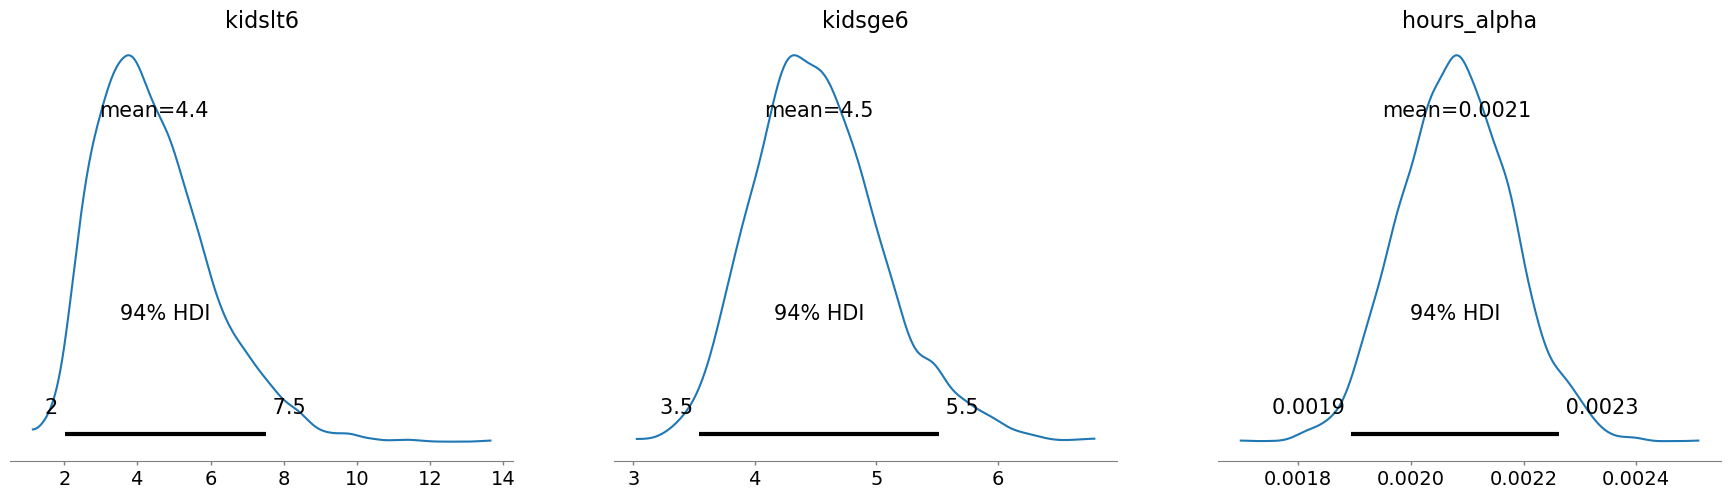

In [68]:
# Initialize the model with additive terms
model_additive = bmb.Model("hours ~ 0 + kidslt6 + kidsge6", data, family="negativebinomial")

# Fit the model
results_additive = model_additive.fit()
# Visualize posterior distributions and credible intervals
az.plot_posterior(results_additive)

"""Credible intervals are more directly interpretable as statements about the uncertainty 
in the parameter's value given the data and prior beliefs, while confidence intervals are 
statements about the procedure used to construct the interval in repeated sampling."""

In [85]:
model_additive

       Formula: hours ~ 0 + kidslt6 + kidsge6
        Family: negativebinomial
          Link: mu = log
  Observations: 753
        Priors: 
    target = mu
        Common-level effects
            kidslt6 ~ Normal(mu: 0.0, sigma: 4.7745)
            kidsge6 ~ Normal(mu: 0.0, sigma: 1.8954)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [86]:
"""To predict whether a woman is in the labor force (the inlf column), which is a binary outcome, you would typically use a logistic regression model. Logistic regression is a type of generalized linear model (GLM) that is well-suited for binary classification tasks.
For logistic regression, the likelihood model is the Bernoulli distribution, which models binary outcomes (success or failure). The link function used in logistic regression is the logistic function (or sigmoid function), which maps the linear combination of predictors to the probability of the positive class.

So, the regression family for logistic regression would be:

Likelihood Model: Bernoulli distribution
Link Function: Logistic (or sigmoid) function"""

'To predict whether a woman is in the labor force (the inlf column), which is a binary outcome, you would typically use a logistic regression model. Logistic regression is a type of generalized linear model (GLM) that is well-suited for binary classification tasks.\nFor logistic regression, the likelihood model is the Bernoulli distribution, which models binary outcomes (success or failure). The link function used in logistic regression is the logistic function (or sigmoid function), which maps the linear combination of predictors to the probability of the positive class.\n\nSo, the regression family for logistic regression would be:\n\nLikelihood Model: Bernoulli distribution\nLink Function: Logistic (or sigmoid) function'